In [1]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from keras import Input, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, concatenate
import tensorflow as tf
from keras.models import load_model

# import mpld3

# mpld3.enable_notebook()

sns.set_style('white')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

random_state = 100


Bad key "text.kerning_factor" on line 4 in
C:\Users\Yuval\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data.csv')
eight_cats = ['Overall', 'Potential', 'Age', 'Preferred Foot', 'ST', 'CM', 'CB', 'GKHandling']
df = df[eight_cats + ['Value']]
df.dropna(axis=0, inplace=True)
df = df[df['Value'] != '€ 0']

def to_value(value_str):
    if (value_str[0] == '€'):
        value_str = value_str[1:]
    if (value_str[-1] == 'M'):
        return float(value_str[:-1]) * 1000000
    if (value_str[-1] == 'K'):
        return float(value_str[:-1]) * 1000
    raise ValueError("Error in value " + value_str)

df['Preferred Foot'] = df['Preferred Foot'].apply(lambda f: 1.0 if f == 'Left' else 0.0)
df['Value'] = df['Value'].apply(to_value)
df.head(5)


,Overall,Potential,Age,Preferred Foot,ST,CM,CB,GKHandling,Value
0,94,94,31,1.0,88.0,84.0,47.0,11.0,110500000.0
1,94,94,33,0.0,91.0,81.0,53.0,11.0,77000000.0
2,92,93,26,0.0,84.0,81.0,47.0,9.0,118500000.0
3,91,93,27,0.0,17.0,17.0,17.0,85.0,72000000.0
4,91,92,27,0.0,82.0,87.0,66.0,13.0,102000000.0


In [3]:
def normalize_df(data_frame):
    normalized = pd.DataFrame()
    for column in df.columns:
        mean = data_frame[column].mean()
        stddev = data_frame[column].std()
        normalized[column] = (data_frame[column] - mean) / stddev
    return normalized


sample_amount = 1000

sampled_df = df.sample(n=sample_amount, random_state=random_state)
normalized_df = normalize_df(df)
normalized_sampled_df = normalize_df(sampled_df)


## Correlation Heatmap

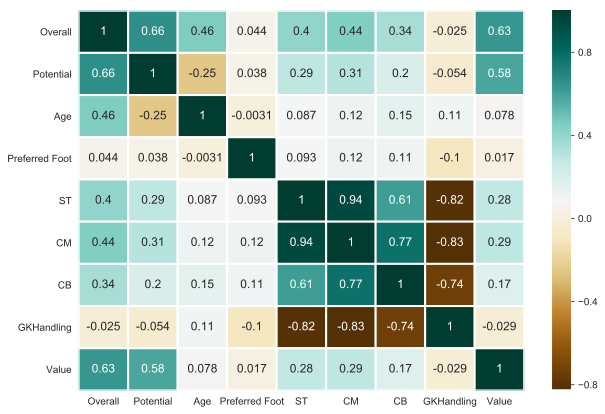

In [4]:
plt.figure(figsize=(10, 7))
_ = sns.heatmap(df.corr(), linecolor='white', linewidths=2.0, annot=True, cmap='BrBG', annot_kws={"size": 12})

## Feature Correlation to Value

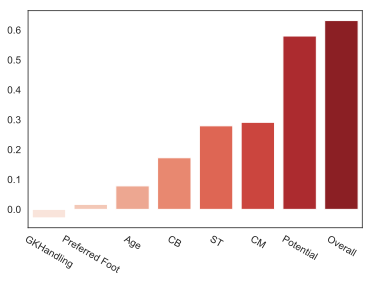

In [5]:
correlation = df.corr()['Value'].sort_values()[:-1]
chart = sns.barplot(x = correlation.index, y = correlation.values, palette='Reds')
_ = chart.set_xticklabels(chart.get_xticklabels(), rotation = -30)

## Feature to Value Plots

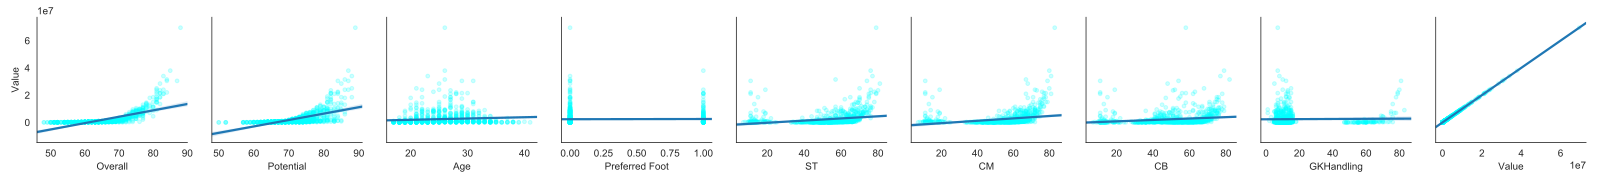

In [6]:

_ = sns.pairplot(data=sampled_df, x_vars=df.columns, y_vars=['Value'], kind="reg", plot_kws={'scatter_kws' : {'color' : 'cyan', 's' : 15, 'alpha' : 0.2}})

## Overall-Age-Value

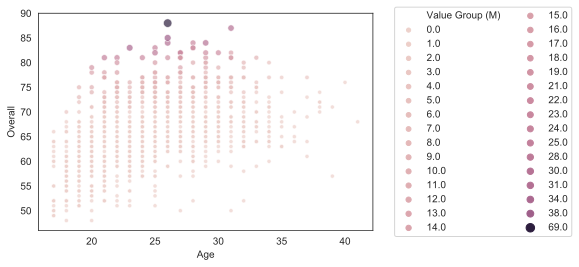

In [7]:
sampled_df['Value Group (M)'] = sampled_df['Value'] // 1000000
g = sns.scatterplot(x = 'Age', y = 'Overall', data=sampled_df, alpha=0.7, size='Value Group (M)', hue='Value Group (M)', legend="full")
g.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)

## Histogram of Values

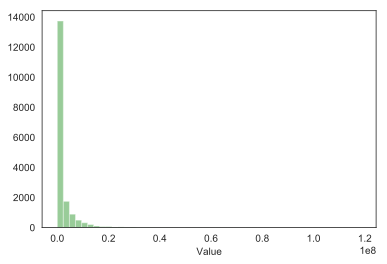

In [8]:
_ = sns.distplot(df['Value'], bins = 50, kde=False, color='green')

## Neural Network Training

In [9]:
test_precent = 0.2
train_precent = 1.0 - test_precent
train_data = normalized_sampled_df.sample(frac=train_precent, random_state=random_state)
test_data = normalized_sampled_df.drop(train_data.index)

train_x = train_data.drop('Value', axis = 1)
train_y = train_data['Value']
test_x = test_data.drop('Value', axis = 1)
test_y = test_data['Value']


In [10]:
def build_fully_NN_model(train):
    input_layer    = Input(shape=(train.shape[1],))
    hidden_layer_1 = Dense(10, activation=tf.nn.relu)(input_layer)
    hidden_layer_2 = Dense(10, activation=tf.nn.relu)(hidden_layer_1)
    output_layer   = Dense(1)(hidden_layer_2)

    model = Model(inputs=[input_layer], outputs=[output_layer])

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

def train_model(model, X, y):
    mc = ModelCheckpoint('best_nn_model.nn', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=30)
    callbacks=[mc, es]
    history = model.fit(X, y, epochs=200, validation_split = 0.2, verbose=0, callbacks=callbacks)
    model = load_model('best_nn_model.nn')
    return history, model

In [11]:
runs_amount = 5
runs = dict()
all_features_label = 'all features'
runs[all_features_label] = []
for i in range(runs_amount):
    fully_NN_model = build_fully_NN_model(train_x)
    fully_NN_history, fully_NN_model = train_model(fully_NN_model, train_x, train_y)
    mse = fully_NN_model.evaluate(test_x, test_y, verbose=0)
    runs[all_features_label].append(mse)
    print('.', end='')

runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)
runs[all_features_label].append(0.0)

.....

In [12]:
def build_halved_model(group1, group2, group3, group4):
    input1 = Input(shape=(len(group1),))
    hidden1_1 = Dense(4, activation='relu')(input1)
    hidden1_2 = Dense(4, activation='relu')(hidden1_1)
    out1 = Dense(1)(hidden1_2)

    input2 = Input(shape=(len(group2),))
    hidden2_1 = Dense(4, activation='relu')(input2)
    hidden2_2 = Dense(4, activation='relu')(hidden2_1)
    out2 = Dense(1)(hidden2_2)

    input3 = Input(shape=(len(group3),))
    hidden3_1 = Dense(4, activation='relu')(input3)
    hidden3_2 = Dense(4, activation='relu')(hidden3_1)
    out3 = Dense(1)(hidden3_2)

    input4 = Input(shape=(len(group4),))
    hidden4_1 = Dense(4, activation='relu')(input4)
    hidden4_2 = Dense(4, activation='relu')(hidden4_1)
    out4 = Dense(1)(hidden4_2)

    merge = concatenate([out1, out2, out3, out4], name='merge')
    output = Dense(1)(merge)

    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model
def calc_halved_NN_mse(g1, g2, g3, g4):
    halved_train_X = [train_x[g1], train_x[g2], train_x[g3], train_x[g4]]
    halved_train_Y = train_y
    halved_test_X = [test_x[g1], test_x[g2], test_x[g3], test_x[g4]]
    halved_test_Y = test_y
    name = (str(g1), str(g2), str(g3), str(g4))
    runs[name] = []
    for i in range(runs_amount):
        halved_model = build_halved_model(g1, g2, g3, g4)
        _, halved_model = train_model(halved_model, halved_train_X, halved_train_Y)
        mse = halved_model.evaluate(halved_test_X, halved_test_Y, verbose=0)
        runs[name].append(mse)
    return name

In [13]:
iteration = 0

def is_lower(g1, g2):
    val1 = g1[0] * 8 + g1[1]
    val2 = g2[0] * 8 + g2[1]
    return val1 < val2

def is_unique(g1, g2, g3, g4):
    vals = g1 + g2 + g3 + g4
    return len(vals) == len(set(vals))

def all_2_2_2_2():
    all_combinations = list(itertools.combinations(list(range(8)), 2))
    combinations = []
    for g1 in all_combinations:
        for g2 in all_combinations:
            if is_lower(g1, g2):
                for g3 in all_combinations:
                    if is_lower(g2, g3):
                        for g4 in all_combinations:
                            if is_lower(g3, g4):
                                if is_unique(g1, g2, g3, g4):
                                    combinations.append((g1, g2, g3, g4))
    return combinations

In [14]:
corr = df.corr().values

def get_corr(subset):
    return corr[subset[0], subset[1]]
for subset1, subset2, subset3, subset4 in all_2_2_2_2():
    g1 = [eight_cats[i] for i in subset1]
    g2 = [eight_cats[i] for i in subset2]
    g3 = [eight_cats[i] for i in subset3]
    g4 = [eight_cats[i] for i in subset4]

    name = calc_halved_NN_mse(g1, g2, g3, g4)

    runs[name].append(get_corr(subset1))
    runs[name].append(get_corr(subset2))
    runs[name].append(get_corr(subset3))
    runs[name].append(get_corr(subset4))
    print('.', end= '')
    iteration += 1
    pd.DataFrame(runs).transpose().to_csv('NN_test_set_prediction_results' + str(iteration) + '.csv')


.........................................................................................................